# KPI: Utilization rate
To show the utilization of the bike sharing service, we calculate the utilization rate. It denotes the proportion of bikes used per hour out of the total number of available bikes in the provider's fleet.
$$ \text{utilization rate} = {\text{used bikes}\over \text{amount of available bikes}} $$
### Load data
In *data_preparation.ipynb* we have already created a table in which the trips have been decomposed according to the times of day (hours). This allows us to easily calculate the utilization rate based on the number of rows in a given hour.

In [7]:
import pandas as pd
import numpy as np
df_splitted_trips = pd.read_csv('./data/prepared/rides_data_split_into_hours.csv', dtype={'start_station_id': np.int64, 'end_station_id': 'string', 'end_station_name': 'string', 'start_station_name': 'string', 'bike_id': np.int64, 'user_type': 'string'})
df_splitted_trips['start_time'] = pd.to_datetime(df_splitted_trips['start_time'], format='%Y-%m-%d %X')
df_splitted_trips['end_time'] = pd.to_datetime(df_splitted_trips['end_time'], format='%Y-%m-%d %X')
df_splitted_trips['Date'] = df_splitted_trips['start_time'].dt.date
df_splitted_trips['Time of day (hour)'] = df_splitted_trips['start_time'].dt.hour
df_splitted_trips.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,trip_length,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,date_time,times_tmp,Date,Time of day (hour)
0,2015-01-01 00:21:44,2015-01-01 00:30:47,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,277,Subscriber,543.0,42.387995,-71.119084,42.373379,-71.111075,2015-01-01 00:00:00,NaN,2015-01-01,0
1,2015-01-01 00:27:03,2015-01-01 00:34:21,80,95,MIT Stata Center at Vassar St / Main St,Cambridge St - at Columbia St / Webster Ave,648,Subscriber,438.0,42.361962,-71.092053,42.372969,-71.094445,2015-01-01 00:00:00,NaN,2015-01-01,0
2,2015-01-01 00:31:31,2015-01-01 00:35:46,91,68,One Kendall Square at Hampshire St / Portland St,Central Square at Mass Ave / Essex St,555,Subscriber,255.0,42.366277,-71.091690,42.365070,-71.103100,2015-01-01 01:00:00,NaN,2015-01-01,0
3,2015-01-01 00:53:46,2015-01-01 00:59:59,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,1307,Subscriber,432.0,42.387995,-71.119084,42.373379,-71.111075,2015-01-01 01:00:00,2015-01-01 00:59:59,2015-01-01,0
4,2015-01-01 01:00:00,2015-01-01 01:00:58,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,1307,Subscriber,432.0,42.387995,-71.119084,42.373379,-71.111075,2015-01-01 01:00:00,2015-01-01 01:00:00,2015-01-01,1


### Calculate utilization rate per hour

In [130]:
import seaborn as sns
amountOfBikes = len(df_splitted_trips['bike_id'].unique())
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_utilization_rate_per_hour = df_splitted_trips.copy()

df_utilization_rate_per_hour['Weekday'] = df_utilization_rate_per_hour['start_time'].dt.day_name()
df_utilization_rate_per_hour = df_utilization_rate_per_hour.groupby(['Date', 'Weekday', 'Time of day (hour)']).nunique()
df_utilization_rate_per_hour['Utilization rate in %'] = df_utilization_rate_per_hour['bike_id']/amountOfBikes*100
df_utilization_rate_per_hour.head()

start_time  end_time  \
Date       Weekday  Time of day (hour)                         
2015-01-01 Thursday 0                            4         4   
                    1                            4         4   
                    2                            1         1   
                    4                            1         1   
                    8                            4         4   

                                        start_station_id  end_station_id  \
Date       Weekday  Time of day (hour)                                     
2015-01-01 Thursday 0                                  3               3   
                    1                                  4               4   
                    2                                  1               1   
                    4                                  1               1   
                    8                                  4               4   

                                        start_station_name  end_station_name  \
Date       Weekday  Time of day (hour)                                         
2015-01-01 Thursday 0                                    3                 3   
                    1                                    4                 4   
                    2                                    1                 1   
                    4                                    1                 1   
                    8                                    4                 4   

                                        bike_id  user_type  trip_length  \
Date       Weekday  Time of day (hour)                                    
2015-01-01 Thursday 0                         4          1            4   
                    1                         4          2            4   
                    2                         1          1            1   
                    4                         1          1            1   
                    8                         3          1            4   

                                        start_station_latitude  \
Date       Weekday  Time of day (hour)                           
2015-01-01 Thursday 0                                        3   
                    1                                        4   
                    2                                        1   
                    4                                        1   
                    8                                        4   

                                        start_station_longitude  \
Date       Weekday  Time of day (hour)                            
2015-01-01 Thursday 0                                         3   
                    1                                         4   
                    2                                         1   
                    4                                         1   
                    8                                         4   

                                        end_station_latitude  \
Date       Weekday  Time of day (hour)                         
2015-01-01 Thursday 0                                      3   
                    1                                      4   
                    2                                      1   
                    4                                      1   
                    8                                      4   

                                        end_station_longitude  date_time  \
Date       Weekday  Time of day (hour)                                     
2015-01-01 Thursday 0                                       3          2   
                    1                                       4          2   
                    2                                       1          1   
                    4                                       1          1   
                    8                                       4          2   

                                        times_tmp  Utili

### Insert utilization rate of 0 for hours without ride

In [181]:
df_utilization_rate_per_hour_reset = df_utilization_rate_per_hour.reset_index(level=1)

indexes = df_utilization_rate_per_hour_reset.index.to_list()
hours = set(range(24))

dict_rides_with_hours = {}
for index in indexes:
    if index[0] not in dict_rides_with_hours.keys():
        dict_rides_with_hours[index[0]] = set([index[1]])
    else:
        dict_rides_with_hours[index[0]].add(index[1])
dict_rides_without_hours = {}
for key, value in dict_rides_with_hours.items():
    missing_hours = hours - value
    if key not in dict_rides_without_hours.keys():
        dict_rides_without_hours[key] = missing_hours
df_utilization_rate_per_hour_reset2 = df_utilization_rate_per_hour_reset.reset_index()
df_utilization_rate_per_hour_reduced = df_utilization_rate_per_hour_reset2[['Date','Time of day (hour)','Utilization rate in %']]

#print(dict_rides_without_hours)
for key, value in dict_rides_without_hours.items():
    for hour in value:
        df_utilization_rate_per_hour_reduced.loc[len(df_utilization_rate_per_hour_reduced.index)] = [key, hour, 0]
    
df_utilization_rate_per_hour_reduced.sort_values(by=['Date', 'Time of day (hour)'], inplace=True)        
df_utilization_rate_per_hour_reduced

/tmp/ipykernel_30415/2353459904.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_utilization_rate_per_hour_reduced.loc[len(df_utilization_rate_per_hour_reduced.index)] = [key, hour, 0]
/tmp/ipykernel_30415/2353459904.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_utilization_rate_per_hour_reduced.loc[len(df_utilization_rate_per_hour_reduced.index)] = [key, hour, 0]
/tmp/ipykernel_30415/2353459904.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

,Date,Time of day (hour),Utilization rate in %
0,2015-01-01,0,0.268817
1,2015-01-01,1,0.268817
2,2015-01-01,2,0.067204
8386,2015-01-01,3,0.000000
3,2015-01-01,4,0.067204
...,...,...,...
8731,2016-01-01,19,0.000000
8732,2016-01-01,20,0.000000
8733,2016-01-01,21,0.000000
8734,2016-01-01,22,0.000000


### Boxplot: Distribution of hourly utilization rate

<AxesSubplot: xlabel='Time of day (hour)', ylabel='Utilization rate in %'>

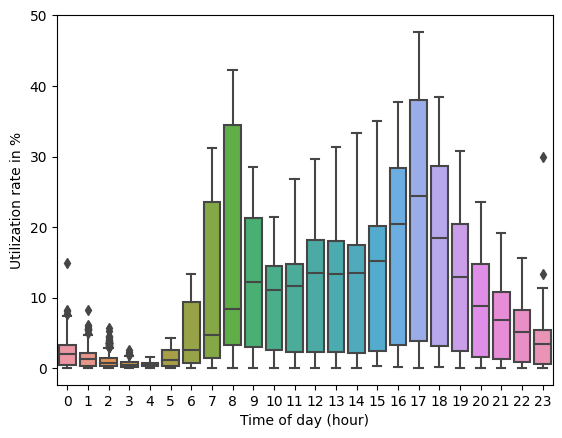

In [37]:
df_utilization_rate_per_hour_reset_index = df_utilization_rate_per_hour.reset_index(level=2)
sns.boxplot(data=df_utilization_rate_per_hour_reset_index, x='Time of day (hour)', y='Utilization rate in %')

Findings:
- This is an asymmetric distribution, as the median is usually not in the middle of the box
- The wide interquartile ranges (wide boxes) indicate that the dispersion is large and the Utilization Rate per hour differs greatly. In particular, during the hours of 6 am to 11 pm, the dispersion is large.
- From 6 am to 11 pm, the boxplots also show long whiskers. This also indicates a broad distribution.
- Outliers only appear at the times between 11 pm and 3 am
- The boxplots show a wide range, especially during the day. At 5 pm, for example, utilization rates of approx. 0 to approx. 47 % can be observed.

In [ ]:
df_utilization_rate_median_per_hour = df_utilization_rate_per_hour.groupby(['Weekday','Time of day (hour)'])['Utilization rate in %'].median().reset_index()

# Sort weekdays as defined in days list
df_utilization_rate_median_per_hour['Weekday'] = pd.Categorical(df_utilization_rate_median_per_hour['Weekday'],categories=days)
df_utilization_rate_median_per_hour = df_utilization_rate_median_per_hour.sort_values('Weekday')

# Plot median of hourly utilization rate grouped by weekdays
sns.lineplot(data=df_utilization_rate_median_per_hour, x='Time of day (hour)', y='Utilization rate in %', hue='Weekday')

### Median of utilization rate per day

<AxesSubplot: xlabel='Date', ylabel='Utilization Rate'>

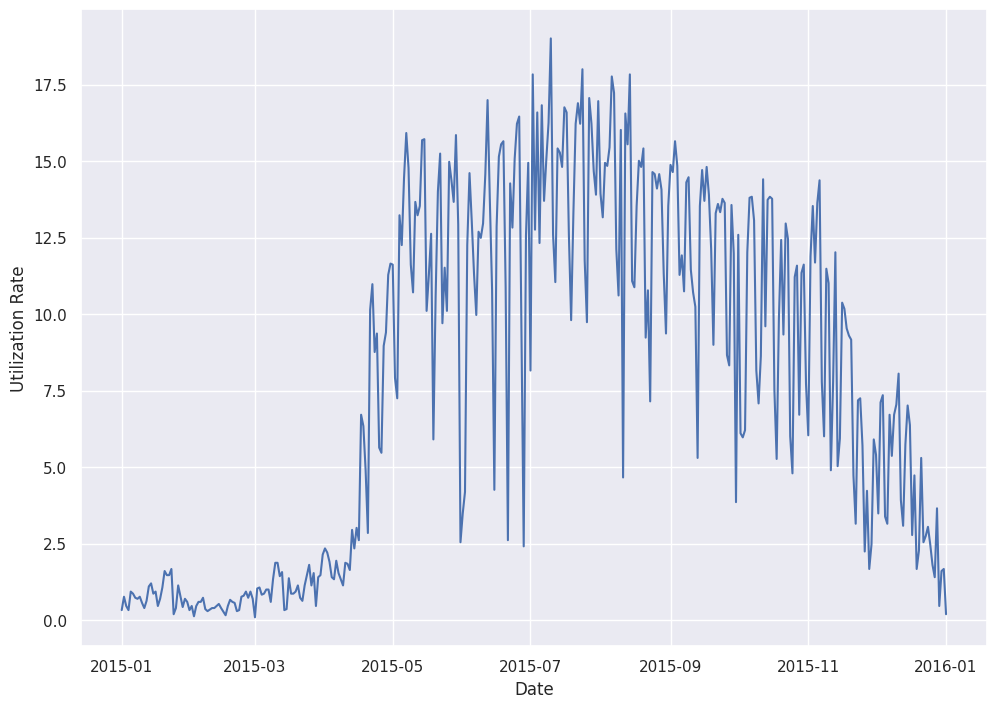

In [ ]:
# Get prepared data
df_utilization_rate_per_day = df_splitted_trips.copy()

# Get number of unique values grouped by date and time of day
df_utilization_rate_per_day = df_utilization_rate_per_day.groupby(['Date', 'Time of day (hour)']).nunique()

# Calculate utilization rate
df_utilization_rate_per_day['Utilization Rate'] = df_utilization_rate_per_day['bike_id']/amountOfBikes*100

# Calculate median for utilization rate per day
df_utilization_rate_per_day = df_utilization_rate_per_day.groupby('Date')['Utilization Rate'].median().reset_index()

# Plot median utilizaiton rate per day
sns.lineplot(data=df_utilization_rate_per_day, x='Date', y='Utilization Rate')

### Median of utilization rate per week

In [ ]:
# Get prepared data
df_utilization_rate_per_week = df_splitted_trips.copy()

# Insert column week
df_utilization_rate_per_week['Week'] = df_utilization_rate_per_week['start_time'].dt.isocalendar().week

# Get number of unique values grouped by week and time of day
df_utilization_rate_per_week = df_utilization_rate_per_week.groupby(['Date', 'Week', 'Time of day (hour)']).nunique()

# Calculate utilization rate
df_utilization_rate_per_week['Utilization Rate'] = df_utilization_rate_per_week['bike_id']/amountOfBikes*100

# Calculate median for utilization rate per day
df_utilization_rate_per_week = df_utilization_rate_per_week.groupby(['Week', 'Time of day (hour)'])['Utilization Rate'].median().reset_index()
df_utilization_rate_per_week = df_utilization_rate_per_week.groupby('Week')['Utilization Rate'].median().reset_index()

# Plot median utilizaiton rate per day
sns.lineplot(data=df_utilization_rate_per_week, x='Week', y='Utilization Rate')

NameError: name 'df_splitted_trips' is not defined

### Coverage

### Revenue

### Clustering